In [4]:
import math
import matplotlib.pyplot as plt
import random
import numpy as np
# calculus
import sympy as sym
# gamma
from scipy.special import gamma, gammaln
from mpmath import mp, gamma
mp.dps = 10  # You can set this to be high enough to handle the precision you need

## Capture probability function

In [5]:
# consider x and y
def P_cap(Px, Py, CR):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = math.sqrt(Py * Pr / Px)
    slope_2 = math.sqrt(Py / (Px * Pr))

    if slope_1 > 1 and slope_2 < 1:
        result = (1 / math.sqrt(Pr * Py / Px) / 2) + (math.sqrt(Py / (Pr * Px)) / 2)
    elif slope_1 > 1 and slope_2 >= 1:
        result = 1 - (1 / math.sqrt(Py / (Pr * Px)) - 1 / math.sqrt(Pr * Py / Px)) / 2
    elif slope_1 <= 1 and slope_2 < 1:
        result = 1 - (math.sqrt(Pr * Py / Px) - math.sqrt(Py / (Pr * Px))) / 2
    return result

# only consider x capture
def P_cap_only_x(Px, Py, CR):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = math.sqrt(Py * Pr / Px)
    slope_2 = math.sqrt(Py / (Px * Pr))

    if slope_1 > 1 and slope_2 < 1:
        result = (1 / math.sqrt(Pr * Py / Px) / 2)
    elif slope_1 > 1 and slope_2 >= 1:
        result = (1 / math.sqrt(Pr * Py / Px) / 2)
    elif slope_1 <= 1 and slope_2 < 1:
        result = 1 - math.sqrt(Pr*Py/Px) / 2
    return result

In [6]:
def gamma_function(z):
    gamma_result = gamma(mp.mpf(str(z)))
    return gamma_result

In [7]:
def getPower(n, step, scheme):
    if scheme == 1:
        power_sum = 0
        for i in range(step):
            power_sum += 2 ** (i if i <= (step - 1) else (step - 1))
        return power_sum / step
    else:
        return 2 ** (n-1 if n-1 <= (step - 1) else (step - 1))

In [103]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    # 第一步: **$M_i$個STA隨機選擇 $R$ 個RA-RU，剛好 $x$ 個STA選到第一個RA-RU (碰撞)**
    first_RU_have_2_STA_count = 0
    # 第二步：**在碰撞的x個STAs裡有y個第n次傳送STA** (設定n=2)
    collision_STA_have_1_nth_count = 0
    collision_STA_have_2_nth_count = 0
    # 第三步：**在x個STA碰撞下，裡面有y個第n次傳送STA，第n次傳送STA被捕獲**
    have_1_nth_capture_count = 0
    have_2_nth_capture_count = 0

    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]

        #/** statistics */  
        for n in range (1, Lmax+1):
            #/** Calculate capture probability for slot i */
            capture_prob = 0
            if M[i] > 0:
                capture_prob_n_k = 0
                capture_prob_n2 = 0
                Pn = getPower(n=n, step=step, scheme=2)
                capture_prob_n2 += P_cap(Pn, Pn, CR)
                # calculate the capture prob. when n-th with k-th (K!=n)
                for k in range(1, Lmax+1):
                    Pk = getPower(n=k, step=step, scheme=2)
                    if (n != k):
                        if (M[i] > M_i[i][n]):
                            capture_prob_n_k += P_cap_only_x(Pn, Pk, CR) * (M_i[i][k] / (M[i] - M_i[i][n]))
#             if (M[i] != M_i[i][n]):
#                 print(f'i={i}, n={n}, M_i[i][n]={M_i[i][n]},  M[i]={M[i]}')
            if (M[i] >= 2):
                # divided result
                if (n==5 and i==3):
                    first_RU_have_2_STA_count += (1 / Ri[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                    print(f'M_i[i][n]: {M_i[i][n]},  M[i]: {M[i]}')
                    collision_STA_have_1_nth_count += (M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i])
                    collision_STA_have_2_nth_count += ((M_i[i][n] / M[i]) ** 2)
#                     print(f'capture_prob_n_k: {capture_prob_n_k},  capture_prob_n2: {capture_prob_n2}')
                    have_1_nth_capture_count += capture_prob_n_k
                    have_2_nth_capture_count += capture_prob_n2
                
#                 M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i]) + capture_prob * (M_i[i][n] / M[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += capture_prob_n2 * ((M_i[i][n] / M[i]) ** 2) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
                M_i_s[i][n] += capture_prob_n_k * (M_i[i][n] / M[i]) * ((M[i] - M_i[i][n]) / M[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * math.exp(-M[i] / Ri[i])
#                 M_i_s[i][n] = M_i[i][n] * ((1 - 1 / Ri[i]) ** (M[i] - 1)) + capture_prob * (M_i[i][n] / M[i]) * (gamma_function(M[i]+1) / (gamma_function(2+1) * gamma_function(M[i]-2+1)) ) / (Ri[i] ** (2-1)) * ((1 - 1 / Ri[i]) ** (M[i]-2))
            if (M[i] < 2):
                M_i_s[i][n] += M_i[i][n] * math.exp(-M[i] / Ri[i])
#                 M_i_s[i][n] = M_i[i][n] * ((1 - 1 / Ri[i]) ** (M[i] - 1))
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
            M_i_s_C[i] += M_i_s[i][n]
#             if M_i[i][n] < 0 or M_i_s[i][n] < 0 or M_i_f[i][n] < 0:
#                 print(f'i={i}, n={n}, capture_prob={capture_prob}, M_i[i][n]={M_i[i][n]}, M_i_s[i][n]={M_i_s[i][n]}, M_i_f[i][n]={M_i_f[i][n]}')
        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)
    # sta*success_probability 來算 grouping的Ds
    
    return Imax,success_probability,access_delay, utilization, through_put, first_RU_have_2_STA_count, collision_STA_have_1_nth_count, collision_STA_have_2_nth_count, have_1_nth_capture_count, have_2_nth_capture_count

# CR=1.5

In [104]:
R = [9,18,37,74,148]
Lmax = 5
# sta_max = 200
sta_max = 1000
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

first_RU_have_2_STA_list = [ [0] * (sta_max) for _ in range(0, len(R))]
collision_STA_have_1_nth_list = [ [0] * (sta_max) for _ in range(0, len(R))]
collision_STA_have_2_nth_list = [ [0] * (sta_max) for _ in range(0, len(R))]
have_1_nth_capture_list = [ [0] * (sta_max) for _ in range(0, len(R))]
have_2_nth_capture_list = [ [0] * (sta_max) for _ in range(0, len(R))]

# for r in R:
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp, first_RU_have_2_STA, collision_STA_have_1_nth, collision_STA_have_2_nth, have_1_nth_capture, have_2_nth_capture = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=1.5, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U
        
        first_RU_have_2_STA_list[idx][sta-1] = first_RU_have_2_STA
        collision_STA_have_1_nth_list[idx][sta-1] = collision_STA_have_1_nth
        collision_STA_have_2_nth_list[idx][sta-1] = collision_STA_have_2_nth
        have_1_nth_capture_list[idx][sta-1] = have_1_nth_capture
        have_2_nth_capture_list[idx][sta-1] = have_2_nth_capture
        

M_i[i][n]: 0,  M[i]: 2.239341855
M_i[i][n]: 0,  M[i]: 2.663802091
M_i[i][n]: 0,  M[i]: 3.118718303
M_i[i][n]: 0,  M[i]: 3.602202368
M_i[i][n]: 0,  M[i]: 4.112258812
M_i[i][n]: 0,  M[i]: 4.646811892
M_i[i][n]: 0,  M[i]: 5.20373671
M_i[i][n]: 0,  M[i]: 5.780891763
M_i[i][n]: 0,  M[i]: 6.376150742
M_i[i][n]: 0,  M[i]: 6.987431864
M_i[i][n]: 0,  M[i]: 7.612723578
M_i[i][n]: 0,  M[i]: 8.250105927
M_i[i][n]: 0,  M[i]: 8.897767331
M_i[i][n]: 0,  M[i]: 9.554016786
M_i[i][n]: 0,  M[i]: 10.21729179
M_i[i][n]: 0,  M[i]: 10.88616244
M_i[i][n]: 0,  M[i]: 11.55933228
M_i[i][n]: 0,  M[i]: 12.23563629
M_i[i][n]: 0,  M[i]: 12.91403685
M_i[i][n]: 0,  M[i]: 13.59361789
M_i[i][n]: 0,  M[i]: 14.27357796
M_i[i][n]: 0,  M[i]: 14.9532224
M_i[i][n]: 0,  M[i]: 15.63195517
M_i[i][n]: 0,  M[i]: 16.30927038
M_i[i][n]: 0,  M[i]: 16.98474396
M_i[i][n]: 0,  M[i]: 17.65802548
M_i[i][n]: 0,  M[i]: 18.32883039
M_i[i][n]: 0,  M[i]: 18.99693257
M_i[i][n]: 0,  M[i]: 19.66215746
M_i[i][n]: 0,  M[i]: 20.32437567
M_i[i][n]: 0

M_i[i][n]: 0,  M[i]: 152.8437462
M_i[i][n]: 0,  M[i]: 153.4140589
M_i[i][n]: 0,  M[i]: 153.9843716
M_i[i][n]: 0,  M[i]: 154.5546843
M_i[i][n]: 0,  M[i]: 155.124997
M_i[i][n]: 0,  M[i]: 155.6953097
M_i[i][n]: 0,  M[i]: 156.2656224
M_i[i][n]: 0,  M[i]: 156.835935
M_i[i][n]: 0,  M[i]: 157.4062477
M_i[i][n]: 0,  M[i]: 157.9765603
M_i[i][n]: 0,  M[i]: 158.546873
M_i[i][n]: 0,  M[i]: 159.1171856
M_i[i][n]: 0,  M[i]: 159.6874982
M_i[i][n]: 0,  M[i]: 160.2578108
M_i[i][n]: 0,  M[i]: 160.8281234
M_i[i][n]: 0,  M[i]: 161.398436
M_i[i][n]: 0,  M[i]: 161.9687486
M_i[i][n]: 0,  M[i]: 162.5390612
M_i[i][n]: 0,  M[i]: 163.1093738
M_i[i][n]: 0,  M[i]: 163.6796863
M_i[i][n]: 0,  M[i]: 164.2499989
M_i[i][n]: 0,  M[i]: 164.8203115
M_i[i][n]: 0,  M[i]: 165.390624
M_i[i][n]: 0,  M[i]: 165.9609366
M_i[i][n]: 0,  M[i]: 166.5312492
M_i[i][n]: 0,  M[i]: 167.1015617
M_i[i][n]: 0,  M[i]: 167.6718743
M_i[i][n]: 0,  M[i]: 168.2421868
M_i[i][n]: 0,  M[i]: 168.8124993
M_i[i][n]: 0,  M[i]: 169.3828119
M_i[i][n]: 0,  

M_i[i][n]: 0,  M[i]: 304.546875
M_i[i][n]: 0,  M[i]: 305.1171875
M_i[i][n]: 0,  M[i]: 305.6875
M_i[i][n]: 0,  M[i]: 306.2578125
M_i[i][n]: 0,  M[i]: 306.828125
M_i[i][n]: 0,  M[i]: 307.3984375
M_i[i][n]: 0,  M[i]: 307.96875
M_i[i][n]: 0,  M[i]: 308.5390625
M_i[i][n]: 0,  M[i]: 309.109375
M_i[i][n]: 0,  M[i]: 309.6796875
M_i[i][n]: 0,  M[i]: 310.25
M_i[i][n]: 0,  M[i]: 310.8203125
M_i[i][n]: 0,  M[i]: 311.390625
M_i[i][n]: 0,  M[i]: 311.9609375
M_i[i][n]: 0,  M[i]: 312.53125
M_i[i][n]: 0,  M[i]: 313.1015625
M_i[i][n]: 0,  M[i]: 313.671875
M_i[i][n]: 0,  M[i]: 314.2421875
M_i[i][n]: 0,  M[i]: 314.8125
M_i[i][n]: 0,  M[i]: 315.3828125
M_i[i][n]: 0,  M[i]: 315.953125
M_i[i][n]: 0,  M[i]: 316.5234375
M_i[i][n]: 0,  M[i]: 317.09375
M_i[i][n]: 0,  M[i]: 317.6640625
M_i[i][n]: 0,  M[i]: 318.234375
M_i[i][n]: 0,  M[i]: 318.8046875
M_i[i][n]: 0,  M[i]: 319.375
M_i[i][n]: 0,  M[i]: 319.9453125
M_i[i][n]: 0,  M[i]: 320.515625
M_i[i][n]: 0,  M[i]: 321.0859375
M_i[i][n]: 0,  M[i]: 321.65625
M_i[i][n

M_i[i][n]: 0,  M[i]: 453.96875
M_i[i][n]: 0,  M[i]: 454.5390625
M_i[i][n]: 0,  M[i]: 455.109375
M_i[i][n]: 0,  M[i]: 455.6796875
M_i[i][n]: 0,  M[i]: 456.25
M_i[i][n]: 0,  M[i]: 456.8203125
M_i[i][n]: 0,  M[i]: 457.390625
M_i[i][n]: 0,  M[i]: 457.9609375
M_i[i][n]: 0,  M[i]: 458.53125
M_i[i][n]: 0,  M[i]: 459.1015625
M_i[i][n]: 0,  M[i]: 459.671875
M_i[i][n]: 0,  M[i]: 460.2421875
M_i[i][n]: 0,  M[i]: 460.8125
M_i[i][n]: 0,  M[i]: 461.3828125
M_i[i][n]: 0,  M[i]: 461.953125
M_i[i][n]: 0,  M[i]: 462.5234375
M_i[i][n]: 0,  M[i]: 463.09375
M_i[i][n]: 0,  M[i]: 463.6640625
M_i[i][n]: 0,  M[i]: 464.234375
M_i[i][n]: 0,  M[i]: 464.8046875
M_i[i][n]: 0,  M[i]: 465.375
M_i[i][n]: 0,  M[i]: 465.9453125
M_i[i][n]: 0,  M[i]: 466.515625
M_i[i][n]: 0,  M[i]: 467.0859375
M_i[i][n]: 0,  M[i]: 467.65625
M_i[i][n]: 0,  M[i]: 468.2265625
M_i[i][n]: 0,  M[i]: 468.796875
M_i[i][n]: 0,  M[i]: 469.3671875
M_i[i][n]: 0,  M[i]: 469.9375
M_i[i][n]: 0,  M[i]: 470.5078125
M_i[i][n]: 0,  M[i]: 471.078125
M_i[i][n

M_i[i][n]: 0,  M[i]: 56.5004796
M_i[i][n]: 0,  M[i]: 57.15904981
M_i[i][n]: 0,  M[i]: 57.81532867
M_i[i][n]: 0,  M[i]: 58.46938522
M_i[i][n]: 0,  M[i]: 59.12128686
M_i[i][n]: 0,  M[i]: 59.77110053
M_i[i][n]: 0,  M[i]: 60.41889095
M_i[i][n]: 0,  M[i]: 61.06472193
M_i[i][n]: 0,  M[i]: 61.70865581
M_i[i][n]: 0,  M[i]: 62.35075348
M_i[i][n]: 0,  M[i]: 62.99107445
M_i[i][n]: 0,  M[i]: 63.62967676
M_i[i][n]: 0,  M[i]: 64.26661703
M_i[i][n]: 0,  M[i]: 64.90195044
M_i[i][n]: 0,  M[i]: 65.53573075
M_i[i][n]: 0,  M[i]: 66.16801027
M_i[i][n]: 0,  M[i]: 66.79883992
M_i[i][n]: 0,  M[i]: 67.42826921
M_i[i][n]: 0,  M[i]: 68.05634628
M_i[i][n]: 0,  M[i]: 68.68311787
M_i[i][n]: 0,  M[i]: 69.30862941
M_i[i][n]: 0,  M[i]: 69.93292498
M_i[i][n]: 0,  M[i]: 70.55604735
M_i[i][n]: 0,  M[i]: 71.17803802
M_i[i][n]: 0,  M[i]: 71.79893723
M_i[i][n]: 0,  M[i]: 72.41878398
M_i[i][n]: 0,  M[i]: 73.03761605
M_i[i][n]: 0,  M[i]: 73.65547007
M_i[i][n]: 0,  M[i]: 74.27238147
M_i[i][n]: 0,  M[i]: 74.88838458
M_i[i][n]: 

M_i[i][n]: 0,  M[i]: 223.2499963
M_i[i][n]: 0,  M[i]: 223.8437465
M_i[i][n]: 0,  M[i]: 224.4374967
M_i[i][n]: 0,  M[i]: 225.0312468
M_i[i][n]: 0,  M[i]: 225.624997
M_i[i][n]: 0,  M[i]: 226.2187471
M_i[i][n]: 0,  M[i]: 226.8124973
M_i[i][n]: 0,  M[i]: 227.4062474
M_i[i][n]: 0,  M[i]: 227.9999975
M_i[i][n]: 0,  M[i]: 228.5937477
M_i[i][n]: 0,  M[i]: 229.1874978
M_i[i][n]: 0,  M[i]: 229.7812479
M_i[i][n]: 0,  M[i]: 230.374998
M_i[i][n]: 0,  M[i]: 230.9687481
M_i[i][n]: 0,  M[i]: 231.5624982
M_i[i][n]: 0,  M[i]: 232.1562483
M_i[i][n]: 0,  M[i]: 232.7499984
M_i[i][n]: 0,  M[i]: 233.3437484
M_i[i][n]: 0,  M[i]: 233.9374985
M_i[i][n]: 0,  M[i]: 234.5312486
M_i[i][n]: 0,  M[i]: 235.1249987
M_i[i][n]: 0,  M[i]: 235.7187487
M_i[i][n]: 0,  M[i]: 236.3124988
M_i[i][n]: 0,  M[i]: 236.9062488
M_i[i][n]: 0,  M[i]: 237.4999989
M_i[i][n]: 0,  M[i]: 238.093749
M_i[i][n]: 0,  M[i]: 238.687499
M_i[i][n]: 0,  M[i]: 239.2812491
M_i[i][n]: 0,  M[i]: 239.8749991
M_i[i][n]: 0,  M[i]: 240.4687492
M_i[i][n]: 0, 

M_i[i][n]: 0,  M[i]: 392.46875
M_i[i][n]: 0,  M[i]: 393.0625
M_i[i][n]: 0,  M[i]: 393.65625
M_i[i][n]: 0,  M[i]: 394.25
M_i[i][n]: 0,  M[i]: 394.84375
M_i[i][n]: 0,  M[i]: 395.4375
M_i[i][n]: 0,  M[i]: 396.03125
M_i[i][n]: 0,  M[i]: 396.625
M_i[i][n]: 0,  M[i]: 397.21875
M_i[i][n]: 0,  M[i]: 397.8125
M_i[i][n]: 0,  M[i]: 398.40625
M_i[i][n]: 0,  M[i]: 399.0
M_i[i][n]: 0,  M[i]: 399.59375
M_i[i][n]: 0,  M[i]: 400.1875
M_i[i][n]: 0,  M[i]: 400.78125
M_i[i][n]: 0,  M[i]: 401.375
M_i[i][n]: 0,  M[i]: 401.96875
M_i[i][n]: 0,  M[i]: 402.5625
M_i[i][n]: 0,  M[i]: 403.15625
M_i[i][n]: 0,  M[i]: 403.75
M_i[i][n]: 0,  M[i]: 404.34375
M_i[i][n]: 0,  M[i]: 404.9375
M_i[i][n]: 0,  M[i]: 405.53125
M_i[i][n]: 0,  M[i]: 406.125
M_i[i][n]: 0,  M[i]: 406.71875
M_i[i][n]: 0,  M[i]: 407.3125
M_i[i][n]: 0,  M[i]: 407.90625
M_i[i][n]: 0,  M[i]: 408.5
M_i[i][n]: 0,  M[i]: 409.09375
M_i[i][n]: 0,  M[i]: 409.6875
M_i[i][n]: 0,  M[i]: 410.28125
M_i[i][n]: 0,  M[i]: 410.875
M_i[i][n]: 0,  M[i]: 411.46875
M_i[i][

M_i[i][n]: 0,  M[i]: 567.03125
M_i[i][n]: 0,  M[i]: 567.625
M_i[i][n]: 0,  M[i]: 568.21875
M_i[i][n]: 0,  M[i]: 568.8125
M_i[i][n]: 0,  M[i]: 569.40625
M_i[i][n]: 0,  M[i]: 570.0
M_i[i][n]: 0,  M[i]: 570.59375
M_i[i][n]: 0,  M[i]: 571.1875
M_i[i][n]: 0,  M[i]: 571.78125
M_i[i][n]: 0,  M[i]: 572.375
M_i[i][n]: 0,  M[i]: 572.96875
M_i[i][n]: 0,  M[i]: 573.5625
M_i[i][n]: 0,  M[i]: 574.15625
M_i[i][n]: 0,  M[i]: 574.75
M_i[i][n]: 0,  M[i]: 575.34375
M_i[i][n]: 0,  M[i]: 575.9375
M_i[i][n]: 0,  M[i]: 576.53125
M_i[i][n]: 0,  M[i]: 577.125
M_i[i][n]: 0,  M[i]: 577.71875
M_i[i][n]: 0,  M[i]: 578.3125
M_i[i][n]: 0,  M[i]: 578.90625
M_i[i][n]: 0,  M[i]: 579.5
M_i[i][n]: 0,  M[i]: 580.09375
M_i[i][n]: 0,  M[i]: 580.6875
M_i[i][n]: 0,  M[i]: 581.28125
M_i[i][n]: 0,  M[i]: 581.875
M_i[i][n]: 0,  M[i]: 582.46875
M_i[i][n]: 0,  M[i]: 583.0625
M_i[i][n]: 0,  M[i]: 583.65625
M_i[i][n]: 0,  M[i]: 584.25
M_i[i][n]: 0,  M[i]: 584.84375
M_i[i][n]: 0,  M[i]: 585.4375
M_i[i][n]: 0,  M[i]: 586.03125
M_i[i][

M_i[i][n]: 0,  M[i]: 293.093865
M_i[i][n]: 0,  M[i]: 294.1127882
M_i[i][n]: 0,  M[i]: 295.1313307
M_i[i][n]: 0,  M[i]: 296.1494996
M_i[i][n]: 0,  M[i]: 297.1673022
M_i[i][n]: 0,  M[i]: 298.1847454
M_i[i][n]: 0,  M[i]: 299.2018362
M_i[i][n]: 0,  M[i]: 300.2185814
M_i[i][n]: 0,  M[i]: 301.2349875
M_i[i][n]: 0,  M[i]: 302.2510611
M_i[i][n]: 0,  M[i]: 303.2668088
M_i[i][n]: 0,  M[i]: 304.2822366
M_i[i][n]: 0,  M[i]: 305.2973509
M_i[i][n]: 0,  M[i]: 306.3121577
M_i[i][n]: 0,  M[i]: 307.326663
M_i[i][n]: 0,  M[i]: 308.3408726
M_i[i][n]: 0,  M[i]: 309.3547924
M_i[i][n]: 0,  M[i]: 310.3684279
M_i[i][n]: 0,  M[i]: 311.3817847
M_i[i][n]: 0,  M[i]: 312.3948682
M_i[i][n]: 0,  M[i]: 313.4076839
M_i[i][n]: 0,  M[i]: 314.4202368
M_i[i][n]: 0,  M[i]: 315.4325323
M_i[i][n]: 0,  M[i]: 316.4445753
M_i[i][n]: 0,  M[i]: 317.4563708
M_i[i][n]: 0,  M[i]: 318.4679236
M_i[i][n]: 0,  M[i]: 319.4792387
M_i[i][n]: 0,  M[i]: 320.4903205
M_i[i][n]: 0,  M[i]: 321.5011739
M_i[i][n]: 0,  M[i]: 322.5118032
M_i[i][n]: 0

M_i[i][n]: 0,  M[i]: 589.9989211
M_i[i][n]: 0,  M[i]: 590.9989466
M_i[i][n]: 0,  M[i]: 591.9989714
M_i[i][n]: 0,  M[i]: 592.9989957
M_i[i][n]: 0,  M[i]: 593.9990193
M_i[i][n]: 0,  M[i]: 594.9990425
M_i[i][n]: 0,  M[i]: 595.9990651
M_i[i][n]: 0,  M[i]: 596.9990871
M_i[i][n]: 0,  M[i]: 597.9991087
M_i[i][n]: 0,  M[i]: 598.9991297
M_i[i][n]: 0,  M[i]: 599.9991503
M_i[i][n]: 0,  M[i]: 600.9991704
M_i[i][n]: 0,  M[i]: 601.99919
M_i[i][n]: 0,  M[i]: 602.9992091
M_i[i][n]: 0,  M[i]: 603.9992278
M_i[i][n]: 0,  M[i]: 604.9992461
M_i[i][n]: 0,  M[i]: 605.9992639
M_i[i][n]: 0,  M[i]: 606.9992813
M_i[i][n]: 0,  M[i]: 607.9992983
M_i[i][n]: 0,  M[i]: 608.9993149
M_i[i][n]: 0,  M[i]: 609.9993311
M_i[i][n]: 0,  M[i]: 610.999347
M_i[i][n]: 0,  M[i]: 611.9993624
M_i[i][n]: 0,  M[i]: 612.9993775
M_i[i][n]: 0,  M[i]: 613.9993923
M_i[i][n]: 0,  M[i]: 614.9994067
M_i[i][n]: 0,  M[i]: 615.9994207
M_i[i][n]: 0,  M[i]: 616.9994344
M_i[i][n]: 0,  M[i]: 617.9994479
M_i[i][n]: 0,  M[i]: 618.9994609
M_i[i][n]: 0,

M_i[i][n]: 0,  M[i]: 844.9999978
M_i[i][n]: 0,  M[i]: 845.9999979
M_i[i][n]: 0,  M[i]: 846.9999979
M_i[i][n]: 0,  M[i]: 847.999998
M_i[i][n]: 0,  M[i]: 848.999998
M_i[i][n]: 0,  M[i]: 849.9999981
M_i[i][n]: 0,  M[i]: 850.9999981
M_i[i][n]: 0,  M[i]: 851.9999982
M_i[i][n]: 0,  M[i]: 852.9999982
M_i[i][n]: 0,  M[i]: 853.9999983
M_i[i][n]: 0,  M[i]: 854.9999983
M_i[i][n]: 0,  M[i]: 855.9999984
M_i[i][n]: 0,  M[i]: 856.9999984
M_i[i][n]: 0,  M[i]: 857.9999984
M_i[i][n]: 0,  M[i]: 858.9999985
M_i[i][n]: 0,  M[i]: 859.9999985
M_i[i][n]: 0,  M[i]: 860.9999985
M_i[i][n]: 0,  M[i]: 861.9999986
M_i[i][n]: 0,  M[i]: 862.9999986
M_i[i][n]: 0,  M[i]: 863.9999986
M_i[i][n]: 0,  M[i]: 864.9999987
M_i[i][n]: 0,  M[i]: 865.9999987
M_i[i][n]: 0,  M[i]: 866.9999987
M_i[i][n]: 0,  M[i]: 867.9999988
M_i[i][n]: 0,  M[i]: 868.9999988
M_i[i][n]: 0,  M[i]: 869.9999988
M_i[i][n]: 0,  M[i]: 870.9999989
M_i[i][n]: 0,  M[i]: 871.9999989
M_i[i][n]: 0,  M[i]: 872.9999989
M_i[i][n]: 0,  M[i]: 873.9999989
M_i[i][n]: 0

M_i[i][n]: 0,  M[i]: 79.40384743
M_i[i][n]: 0,  M[i]: 80.6293639
M_i[i][n]: 0,  M[i]: 81.86018759
M_i[i][n]: 0,  M[i]: 83.09618939
M_i[i][n]: 0,  M[i]: 84.33724116
M_i[i][n]: 0,  M[i]: 85.58321571
M_i[i][n]: 0,  M[i]: 86.83398688
M_i[i][n]: 0,  M[i]: 88.08942953
M_i[i][n]: 0,  M[i]: 89.34941965
M_i[i][n]: 0,  M[i]: 90.61383407
M_i[i][n]: 0,  M[i]: 91.8825512
M_i[i][n]: 0,  M[i]: 93.15545027
M_i[i][n]: 0,  M[i]: 94.43241185
M_i[i][n]: 0,  M[i]: 95.71331766
M_i[i][n]: 0,  M[i]: 96.99805068
M_i[i][n]: 0,  M[i]: 98.28649519
M_i[i][n]: 0,  M[i]: 99.57853674
M_i[i][n]: 0,  M[i]: 100.8740621
M_i[i][n]: 0,  M[i]: 102.1729595
M_i[i][n]: 0,  M[i]: 103.4751184
M_i[i][n]: 0,  M[i]: 104.7804296
M_i[i][n]: 0,  M[i]: 106.0887854
M_i[i][n]: 0,  M[i]: 107.4000793
M_i[i][n]: 0,  M[i]: 108.7142064
M_i[i][n]: 0,  M[i]: 110.031063
M_i[i][n]: 0,  M[i]: 111.3505469
M_i[i][n]: 0,  M[i]: 112.6725573
M_i[i][n]: 0,  M[i]: 113.9969948
M_i[i][n]: 0,  M[i]: 115.3237614
M_i[i][n]: 0,  M[i]: 116.6527608
M_i[i][n]: 0,

M_i[i][n]: 0,  M[i]: 400.129933
M_i[i][n]: 0,  M[i]: 401.2336837
M_i[i][n]: 0,  M[i]: 402.3365224
M_i[i][n]: 0,  M[i]: 403.4384559
M_i[i][n]: 0,  M[i]: 404.539491
M_i[i][n]: 0,  M[i]: 405.6396345
M_i[i][n]: 0,  M[i]: 406.7388931
M_i[i][n]: 0,  M[i]: 407.8372736
M_i[i][n]: 0,  M[i]: 408.9347827
M_i[i][n]: 0,  M[i]: 410.0314271
M_i[i][n]: 0,  M[i]: 411.1272132
M_i[i][n]: 0,  M[i]: 412.2221479
M_i[i][n]: 0,  M[i]: 413.3162375
M_i[i][n]: 0,  M[i]: 414.4094887
M_i[i][n]: 0,  M[i]: 415.5019079
M_i[i][n]: 0,  M[i]: 416.5935016
M_i[i][n]: 0,  M[i]: 417.6842762
M_i[i][n]: 0,  M[i]: 418.7742381
M_i[i][n]: 0,  M[i]: 419.8633937
M_i[i][n]: 0,  M[i]: 420.9517492
M_i[i][n]: 0,  M[i]: 422.039311
M_i[i][n]: 0,  M[i]: 423.1260853
M_i[i][n]: 0,  M[i]: 424.2120784
M_i[i][n]: 0,  M[i]: 425.2972963
M_i[i][n]: 0,  M[i]: 426.3817453
M_i[i][n]: 0,  M[i]: 427.4654314
M_i[i][n]: 0,  M[i]: 428.5483608
M_i[i][n]: 0,  M[i]: 429.6305395
M_i[i][n]: 0,  M[i]: 430.7119734
M_i[i][n]: 0,  M[i]: 431.7926686
M_i[i][n]: 0,

M_i[i][n]: 0,  M[i]: 717.5539363
M_i[i][n]: 0,  M[i]: 718.5588229
M_i[i][n]: 0,  M[i]: 719.5636573
M_i[i][n]: 0,  M[i]: 720.5684401
M_i[i][n]: 0,  M[i]: 721.5731718
M_i[i][n]: 0,  M[i]: 722.5778528
M_i[i][n]: 0,  M[i]: 723.5824838
M_i[i][n]: 0,  M[i]: 724.5870652
M_i[i][n]: 0,  M[i]: 725.5915976
M_i[i][n]: 0,  M[i]: 726.5960814
M_i[i][n]: 0,  M[i]: 727.6005172
M_i[i][n]: 0,  M[i]: 728.6049055
M_i[i][n]: 0,  M[i]: 729.6092467
M_i[i][n]: 0,  M[i]: 730.6135414
M_i[i][n]: 0,  M[i]: 731.6177901
M_i[i][n]: 0,  M[i]: 732.6219931
M_i[i][n]: 0,  M[i]: 733.626151
M_i[i][n]: 0,  M[i]: 734.6302643
M_i[i][n]: 0,  M[i]: 735.6343334
M_i[i][n]: 0,  M[i]: 736.6383588
M_i[i][n]: 0,  M[i]: 737.6423409
M_i[i][n]: 0,  M[i]: 738.6462802
M_i[i][n]: 0,  M[i]: 739.6501771
M_i[i][n]: 0,  M[i]: 740.6540321
M_i[i][n]: 0,  M[i]: 741.6578456
M_i[i][n]: 0,  M[i]: 742.6616181
M_i[i][n]: 0,  M[i]: 743.6653499
M_i[i][n]: 0,  M[i]: 744.6690416
M_i[i][n]: 0,  M[i]: 745.6726934
M_i[i][n]: 0,  M[i]: 746.6763059
M_i[i][n]: 

M_i[i][n]: 0,  M[i]: 968.974082
M_i[i][n]: 0,  M[i]: 969.9743811
M_i[i][n]: 0,  M[i]: 970.9746769
M_i[i][n]: 0,  M[i]: 971.9749692
M_i[i][n]: 0,  M[i]: 972.9752583
M_i[i][n]: 0,  M[i]: 973.975544
M_i[i][n]: 0,  M[i]: 974.9758265
M_i[i][n]: 0,  M[i]: 975.9761058
M_i[i][n]: 0,  M[i]: 976.9763819
M_i[i][n]: 0,  M[i]: 977.9766548
M_i[i][n]: 0,  M[i]: 978.9769246
M_i[i][n]: 0,  M[i]: 979.9771914
M_i[i][n]: 0,  M[i]: 980.9774551
M_i[i][n]: 0,  M[i]: 981.9777158
M_i[i][n]: 0,  M[i]: 982.9779735
M_i[i][n]: 0,  M[i]: 983.9782282
M_i[i][n]: 0,  M[i]: 984.9784801
M_i[i][n]: 0,  M[i]: 985.9787291
M_i[i][n]: 0,  M[i]: 986.9789753
M_i[i][n]: 0,  M[i]: 987.9792186
M_i[i][n]: 0,  M[i]: 988.9794591
M_i[i][n]: 0,  M[i]: 989.979697
M_i[i][n]: 0,  M[i]: 990.979932
M_i[i][n]: 0,  M[i]: 991.9801644
M_i[i][n]: 0,  M[i]: 992.9803942
M_i[i][n]: 0,  M[i]: 993.9806213
M_i[i][n]: 0,  M[i]: 994.9808458
M_i[i][n]: 0,  M[i]: 995.9810678
M_i[i][n]: 0,  M[i]: 996.9812872
M_i[i][n]: 0,  M[i]: 997.9815041
M_i[i][n]: 0, 

M_i[i][n]: 0,  M[i]: 179.7219605
M_i[i][n]: 0,  M[i]: 180.9881588
M_i[i][n]: 0,  M[i]: 182.2565122
M_i[i][n]: 0,  M[i]: 183.5269903
M_i[i][n]: 0,  M[i]: 184.799563
M_i[i][n]: 0,  M[i]: 186.0742002
M_i[i][n]: 0,  M[i]: 187.350872
M_i[i][n]: 0,  M[i]: 188.6295488
M_i[i][n]: 0,  M[i]: 189.9102009
M_i[i][n]: 0,  M[i]: 191.1927988
M_i[i][n]: 0,  M[i]: 192.4773135
M_i[i][n]: 0,  M[i]: 193.7637157
M_i[i][n]: 0,  M[i]: 195.0519765
M_i[i][n]: 0,  M[i]: 196.3420671
M_i[i][n]: 0,  M[i]: 197.6339589
M_i[i][n]: 0,  M[i]: 198.9276235
M_i[i][n]: 0,  M[i]: 200.2230326
M_i[i][n]: 0,  M[i]: 201.5201579
M_i[i][n]: 0,  M[i]: 202.8189717
M_i[i][n]: 0,  M[i]: 204.119446
M_i[i][n]: 0,  M[i]: 205.4215534
M_i[i][n]: 0,  M[i]: 206.7252662
M_i[i][n]: 0,  M[i]: 208.0305573
M_i[i][n]: 0,  M[i]: 209.3373995
M_i[i][n]: 0,  M[i]: 210.6457659
M_i[i][n]: 0,  M[i]: 211.9556297
M_i[i][n]: 0,  M[i]: 213.2669643
M_i[i][n]: 0,  M[i]: 214.5797434
M_i[i][n]: 0,  M[i]: 215.8939407
M_i[i][n]: 0,  M[i]: 217.2095301
M_i[i][n]: 0,

M_i[i][n]: 0,  M[i]: 515.1978305
M_i[i][n]: 0,  M[i]: 516.4652319
M_i[i][n]: 0,  M[i]: 517.7318003
M_i[i][n]: 0,  M[i]: 518.9975353
M_i[i][n]: 0,  M[i]: 520.2624371
M_i[i][n]: 0,  M[i]: 521.5265057
M_i[i][n]: 0,  M[i]: 522.789741
M_i[i][n]: 0,  M[i]: 524.0521432
M_i[i][n]: 0,  M[i]: 525.3137124
M_i[i][n]: 0,  M[i]: 526.5744488
M_i[i][n]: 0,  M[i]: 527.8343524
M_i[i][n]: 0,  M[i]: 529.0934237
M_i[i][n]: 0,  M[i]: 530.3516626
M_i[i][n]: 0,  M[i]: 531.6090697
M_i[i][n]: 0,  M[i]: 532.8656451
M_i[i][n]: 0,  M[i]: 534.1213892
M_i[i][n]: 0,  M[i]: 535.3763023
M_i[i][n]: 0,  M[i]: 536.630385
M_i[i][n]: 0,  M[i]: 537.8836375
M_i[i][n]: 0,  M[i]: 539.1360603
M_i[i][n]: 0,  M[i]: 540.387654
M_i[i][n]: 0,  M[i]: 541.638419
M_i[i][n]: 0,  M[i]: 542.8883558
M_i[i][n]: 0,  M[i]: 544.1374651
M_i[i][n]: 0,  M[i]: 545.3857474
M_i[i][n]: 0,  M[i]: 546.6332034
M_i[i][n]: 0,  M[i]: 547.8798337
M_i[i][n]: 0,  M[i]: 549.1256389
M_i[i][n]: 0,  M[i]: 550.3706197
M_i[i][n]: 0,  M[i]: 551.614777
M_i[i][n]: 0,  

M_i[i][n]: 0,  M[i]: 874.3576558
M_i[i][n]: 0,  M[i]: 875.4342917
M_i[i][n]: 0,  M[i]: 876.5105769
M_i[i][n]: 0,  M[i]: 877.5865126
M_i[i][n]: 0,  M[i]: 878.6621004
M_i[i][n]: 0,  M[i]: 879.7373416
M_i[i][n]: 0,  M[i]: 880.8122376
M_i[i][n]: 0,  M[i]: 881.88679
M_i[i][n]: 0,  M[i]: 882.961
M_i[i][n]: 0,  M[i]: 884.0348691
M_i[i][n]: 0,  M[i]: 885.1083987
M_i[i][n]: 0,  M[i]: 886.1815902
M_i[i][n]: 0,  M[i]: 887.2544449
M_i[i][n]: 0,  M[i]: 888.3269643
M_i[i][n]: 0,  M[i]: 889.3991497
M_i[i][n]: 0,  M[i]: 890.4710026
M_i[i][n]: 0,  M[i]: 891.5425242
M_i[i][n]: 0,  M[i]: 892.613716
M_i[i][n]: 0,  M[i]: 893.6845793
M_i[i][n]: 0,  M[i]: 894.7551155
M_i[i][n]: 0,  M[i]: 895.8253259
M_i[i][n]: 0,  M[i]: 896.8952119
M_i[i][n]: 0,  M[i]: 897.9647748
M_i[i][n]: 0,  M[i]: 899.034016
M_i[i][n]: 0,  M[i]: 900.1029368
M_i[i][n]: 0,  M[i]: 901.1715386
M_i[i][n]: 0,  M[i]: 902.2398226
M_i[i][n]: 0,  M[i]: 903.3077902
M_i[i][n]: 0,  M[i]: 904.3754428
M_i[i][n]: 0,  M[i]: 905.4427815
M_i[i][n]: 0,  M[i

In [97]:
# Simulation (old -> m=200)

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
# m_list_simu = [(i+1)*10 for i in range(20)]
m_list_simu = np.concatenate([np.arange(1, 11, 1), np.arange(20, 110, 10), np.arange(200, 1100, 100)])

first_RU_have_2_STA_list_9_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.001, 0.025, 0.144, 0.256, 0.282, 0.257, 0.197, 0.153, 0.127, 0.093, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
collision_STA_have_1_nth_list_9_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.001, 0.023, 0.116, 0.185, 0.205, 0.165, 0.129, 0.101, 0.091, 0.067, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
collision_STA_have_2_nth_list_9_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.001, 0.023, 0.116, 0.185, 0.205, 0.165, 0.129, 0.101, 0.091, 0.067, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
have_1_nth_capture_list_9_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
have_2_nth_capture_list_9_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021, 0.099, 0.182, 0.19, 0.175, 0.132, 0.103, 0.084, 0.068, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


first_RU_have_2_STA_list_18_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.027, 0.093, 0.213, 0.283, 0.297, 0.233, 0.191, 0.018, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
collision_STA_have_1_nth_list_18_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
collision_STA_have_2_nth_list_18_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
have_1_nth_capture_list_18_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
have_2_nth_capture_list_18_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


first_RU_have_2_STA_list_37_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.007, 0.023, 0.066, 0.151, 0.074, 0.009, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
collision_STA_have_1_nth_list_37_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
collision_STA_have_2_nth_list_37_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
have_1_nth_capture_list_37_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
have_2_nth_capture_list_37_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


first_RU_have_2_STA_list_74_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.164, 0.217, 0.078, 0.026, 0.009, 0.001, 0.001, 0.0, 0.0]
collision_STA_have_1_nth_list_74_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
collision_STA_have_2_nth_list_74_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
have_1_nth_capture_list_74_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
have_2_nth_capture_list_74_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


first_RU_have_2_STA_list_148_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005, 0.159, 0.26, 0.217, 0.153, 0.087, 0.047, 0.033]
collision_STA_have_1_nth_list_148_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
collision_STA_have_2_nth_list_148_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
have_1_nth_capture_list_148_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
have_2_nth_capture_list_148_simu = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

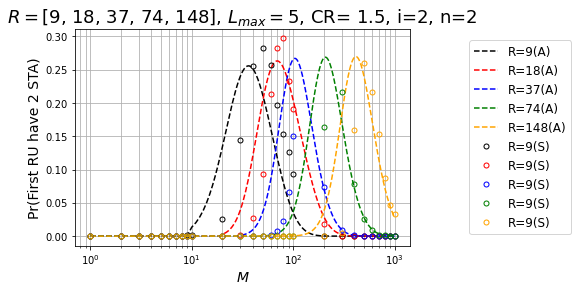

In [98]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, first_RU_have_2_STA_list[0], linestyle = '--', color='black', label='R=9(A)')
plt.semilogx(m_list, first_RU_have_2_STA_list[1], linestyle = '--', color='red', label='R=18(A)')
plt.semilogx(m_list, first_RU_have_2_STA_list[2], linestyle = '--', color='blue', label='R=37(A)')
plt.semilogx(m_list, first_RU_have_2_STA_list[3], linestyle = '--', color='green', label='R=74(A)')
plt.semilogx(m_list, first_RU_have_2_STA_list[4], linestyle = '--', color='orange', label='R=148(A)')

plt.semilogx(m_list_simu, first_RU_have_2_STA_list_9_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, first_RU_have_2_STA_list_18_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, first_RU_have_2_STA_list_37_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, first_RU_have_2_STA_list_74_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, first_RU_have_2_STA_list_148_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5, i=2, n=2', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Pr(First RU have 2 STA)", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

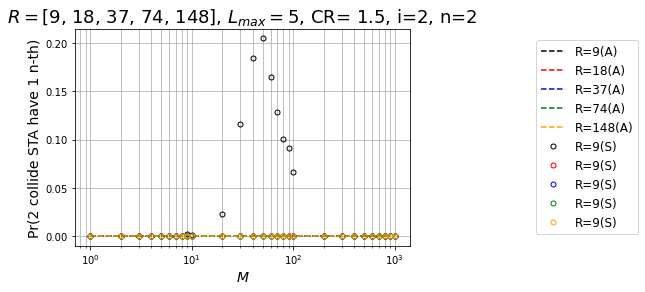

In [99]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, collision_STA_have_1_nth_list[0], linestyle = '--', color='black', label='R=9(A)')
plt.semilogx(m_list, collision_STA_have_1_nth_list[1], linestyle = '--', color='red', label='R=18(A)')
plt.semilogx(m_list, collision_STA_have_1_nth_list[2], linestyle = '--', color='blue', label='R=37(A)')
plt.semilogx(m_list, collision_STA_have_1_nth_list[3], linestyle = '--', color='green', label='R=74(A)')
plt.semilogx(m_list, collision_STA_have_1_nth_list[4], linestyle = '--', color='orange', label='R=148(A)')

plt.semilogx(m_list_simu, collision_STA_have_1_nth_list_9_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, collision_STA_have_1_nth_list_18_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, collision_STA_have_1_nth_list_37_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, collision_STA_have_1_nth_list_74_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, collision_STA_have_1_nth_list_148_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5, i=2, n=2', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Pr(2 collide STA have 1 n-th)", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

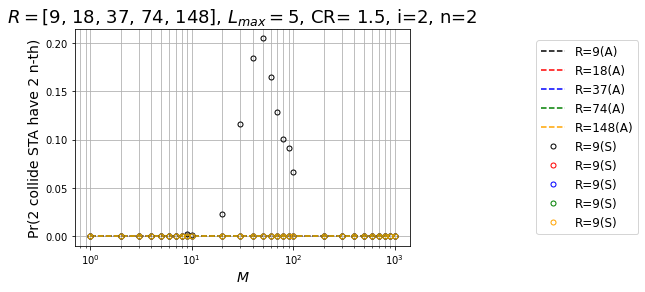

In [100]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, collision_STA_have_2_nth_list[0], linestyle = '--', color='black', label='R=9(A)')
plt.semilogx(m_list, collision_STA_have_2_nth_list[1], linestyle = '--', color='red', label='R=18(A)')
plt.semilogx(m_list, collision_STA_have_2_nth_list[2], linestyle = '--', color='blue', label='R=37(A)')
plt.semilogx(m_list, collision_STA_have_2_nth_list[3], linestyle = '--', color='green', label='R=74(A)')
plt.semilogx(m_list, collision_STA_have_2_nth_list[4], linestyle = '--', color='orange', label='R=148(A)')

plt.semilogx(m_list_simu, collision_STA_have_2_nth_list_9_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, collision_STA_have_2_nth_list_18_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, collision_STA_have_2_nth_list_37_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, collision_STA_have_2_nth_list_74_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, collision_STA_have_2_nth_list_148_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5, i=2, n=2', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Pr(2 collide STA have 2 n-th)", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

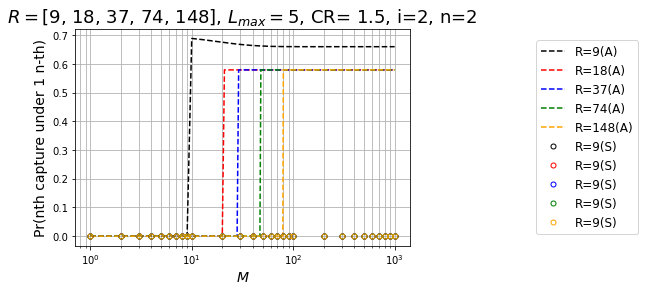

In [101]:
plt.semilogx(m_list, have_1_nth_capture_list[0], linestyle = '--', color='black', label='R=9(A)')
plt.semilogx(m_list, have_1_nth_capture_list[1], linestyle = '--', color='red', label='R=18(A)')
plt.semilogx(m_list, have_1_nth_capture_list[2], linestyle = '--', color='blue', label='R=37(A)')
plt.semilogx(m_list, have_1_nth_capture_list[3], linestyle = '--', color='green', label='R=74(A)')
plt.semilogx(m_list, have_1_nth_capture_list[4], linestyle = '--', color='orange', label='R=148(A)')

plt.semilogx(m_list_simu, have_1_nth_capture_list_9_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, have_1_nth_capture_list_18_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, have_1_nth_capture_list_37_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, have_1_nth_capture_list_74_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, have_1_nth_capture_list_148_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5, i=2, n=2', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Pr(nth capture under 1 n-th)", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

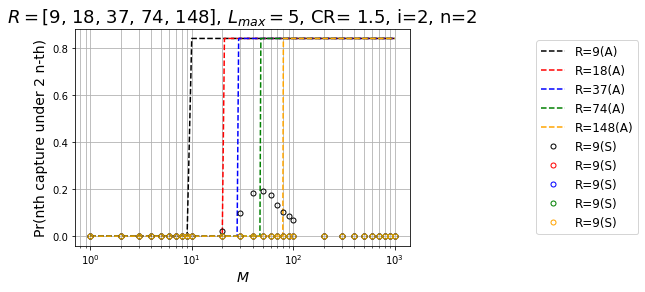

In [102]:
plt.semilogx(m_list, have_2_nth_capture_list[0], linestyle = '--', color='black', label='R=9(A)')
plt.semilogx(m_list, have_2_nth_capture_list[1], linestyle = '--', color='red', label='R=18(A)')
plt.semilogx(m_list, have_2_nth_capture_list[2], linestyle = '--', color='blue', label='R=37(A)')
plt.semilogx(m_list, have_2_nth_capture_list[3], linestyle = '--', color='green', label='R=74(A)')
plt.semilogx(m_list, have_2_nth_capture_list[4], linestyle = '--', color='orange', label='R=148(A)')

plt.semilogx(m_list_simu, have_2_nth_capture_list_9_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, have_2_nth_capture_list_18_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, have_2_nth_capture_list_37_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, have_2_nth_capture_list_74_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, have_2_nth_capture_list_148_simu, label='R=9(S)', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5, i=2, n=2', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Pr(nth capture under 2 n-th)", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.7, 0.5), fontsize = 12)
# plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# CR=3

In [160]:
R = [9,18,37,74,148]
Lmax = 5
# sta_max = 200
sta_max = 1000
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=3, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U

In [161]:
# Simulation (old -> m=200)

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
# m_list_simu = [(i+1)*10 for i in range(20)]
m_list_simu = np.concatenate([np.arange(1, 11, 1), np.arange(20, 110, 10), np.arange(200, 1100, 100)])

ps_list_simu_9 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9993500000000004, 0.9840666666666663, 0.9104000000000012, 0.7697600000000002, 0.6034166666666676, 0.46924285714285646, 0.36623750000000005, 0.2867666666666668, 0.23186999999999955, 0.06791999999999995, 0.038846666666666724, 0.02570499999999995, 0.019869999999999867, 0.015563333333333387, 0.012564285714285682, 0.010462499999999986, 0.009132222222222187, 0.007940999999999969]
da_list_simu_9 = [5.672999999999856, 6.319721999999862, 6.868111999999891, 7.316751749999945, 7.894546799999998, 8.45276999999996, 9.101923285714244, 9.570351000000038, 10.349442999999969, 11.018100600000048, 18.200282818421154, 26.16480426117554, 32.91433568857503, 38.06944863209454, 42.151399118485905, 45.557184619020035, 48.776860431599296, 51.6150576035225, 54.286948649184225, 67.64112753992471, 71.05537814873718, 72.83373922997399, 74.14297259565762, 75.10613391049144, 75.7479671031093, 76.40516623804129, 76.87515564094262, 77.35136577534057]
t_list_simu_9 = [0.06666666666666801, 0.13333333333333602, 0.19999999999999718, 0.26666666666667205, 0.3333333333333318, 0.39999999999999436, 0.46666666666665557, 0.5333333333333441, 0.6000000000000113, 0.6666666666666636, 1.3324666666666607, 1.9681333333333326, 2.4277333333333324, 2.565866666666668, 2.4136666666666704, 2.189800000000004, 1.9532666666666667, 1.7205999999999961, 1.5457999999999992, 0.9055999999999986, 0.7769333333333327, 0.6854666666666672, 0.6623333333333358, 0.6225333333333355, 0.5863333333333365, 0.5580000000000008, 0.5479333333333346, 0.529400000000001]
u_list_simu_9 = [0.007407407407407279, 0.014814814814814559, 0.02222222222222215, 0.029629629629629117, 0.0370370370370375, 0.0444444444444443, 0.051851851851851004, 0.059259259259258235, 0.06666666666666801, 0.074074074074075, 0.14805185185185366, 0.21868148148148417, 0.26974814814814835, 0.28509629629629596, 0.2681851851851845, 0.2433111111111111, 0.21702962962962985, 0.1911777777777777, 0.1717555555555553, 0.10062222222222239, 0.08632592592592579, 0.07616296296296311, 0.07359259259259274, 0.06917037037037047, 0.06514814814814819, 0.06200000000000006, 0.06088148148148149, 0.05882222222222235]
power_list_simu_9 = [1.0, 1.169, 1.3100000000000005, 1.423, 1.5924000000000063, 1.7193333333333316, 1.922000000000007, 2.0535, 2.274222222222222, 2.4715999999999987, 5.019252631578948, 8.89615202110788, 14.078540152692884, 21.22417192510717, 31.41783192134293, 43.91049340476168, 59.22830184591982, 77.9704246015927, 98.67042769854811, 356.1029005942457, 628.1408273938998, 961.6238846003677, 1248.879178893002, 1601.0834689983185, 1985.8212380119999, 2433.060685092685, 2779.7447877122877, 3251.361379959899]


ps_list_simu_18 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9993333333333333, 0.9910750000000036, 0.9454000000000053, 0.8427500000000014, 0.6991428571428591, 0.553575, 0.43086666666666623, 0.3415799999999996, 0.07123, 0.036970000000000065, 0.02424999999999996, 0.017377999999999904, 0.01298666666666671, 0.009368571428571403, 0.0070212499999999815, 0.005193333333333308, 0.003655999999999966]
da_list_simu_18 = [5.672999999999856, 5.8630454999998625, 6.0322899999998745, 6.237463499999918, 6.516007799999951, 6.730068999999918, 6.852983999999952, 7.14017962500001, 7.375530333333314, 7.577993400000049, 10.230436066666721, 13.453333660344823, 17.1733811044067, 20.959688862489195, 23.878595134092812, 26.304198391221238, 28.189073539849023, 29.778801174560357, 31.352737857032132, 41.532578708850444, 44.3159269707425, 45.06740662169023, 45.297319091407594, 45.35192800557249, 45.375222608332194, 45.38049138781525, 45.38399999999885, 45.38303618756258]
t_list_simu_18 = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 2.49975, 3.7475, 4.955375, 5.90875, 6.320625, 6.1175, 5.53575, 4.84725, 4.26975, 1.78075, 1.386375, 1.2125, 1.086125, 0.974, 0.81975, 0.702125, 0.58425, 0.457]
u_list_simu_18 = [0.0069444444444445785, 0.013888888888889157, 0.02083333333333324, 0.027777777777778314, 0.03472222222222164, 0.04166666666666648, 0.048611111111111965, 0.05555555555555663, 0.0625, 0.06944444444444328, 0.13887499999999767, 0.2081944444444469, 0.27529861111110804, 0.3282638888888894, 0.35114583333333316, 0.339861111111111, 0.3075416666666669, 0.26929166666666726, 0.23720833333333322, 0.09893055555555588, 0.07702083333333311, 0.067361111111111, 0.060340277777777854, 0.05411111111111128, 0.045541666666666834, 0.03900694444444456, 0.03245833333333336, 0.025388888888888902]
power_list_simu_18 = [1.0, 1.068, 1.1273333333333322, 1.2055, 1.3007999999999993, 1.3846666666666678, 1.430000000000005, 1.54575, 1.6293333333333244, 1.7120000000000006, 2.903422222222227, 4.699379310344823, 7.431063542534123, 11.450895230471978, 16.697105011016607, 24.197274531920215, 34.42372045922322, 47.60442395216207, 62.83220803922735, 338.0855224088633, 656.0280819758673, 1005.3332075702086, 1428.1103394494369, 1932.6834324009276, 2767.186517094025, 3780.6722943722875, 5412.640032467527, 7901.9968253968445]


ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9996400000000001, 0.9984500000000005, 0.9923142857142844, 0.9650624999999992, 0.9088333333333329, 0.8095399999999994, 0.07020500000000007, 0.005419999999999975, 0.00045750000000000033, 3.400000000000001e-05, 3.3333333333333337e-06, 0.0, 0.0, 0.0, 0.0]
da_list_simu_37 = [5.672999999999856, 5.7666044999998585, 5.865881999999864, 5.953813499999879, 6.089398199999913, 6.108875499999879, 6.307565571428493, 6.377161124999965, 6.429399999999946, 6.561959100000003, 7.597848900000043, 8.621825400000002, 9.723380175000058, 11.077411815000003, 12.556076103790916, 14.168497725666874, 15.780338678412104, 16.9699753376232, 17.817837888024705, 17.653348318985152, 16.866116862623702, 17.08280674846622, 16.68529411764706, 17.019000000000002, 17.019000000000002, 17.019000000000002, 17.019000000000002, 17.019000000000002]
t_list_simu_37 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 9.996400000000001, 11.981400000000006, 13.892400000000015, 15.440999999999987, 16.359000000000005, 16.19079999999998, 2.8081999999999963, 0.3251999999999982, 0.036599999999999966, 0.0034000000000000007, 0.0004, 0.0, 0.0, 0.0, 0.0]
u_list_simu_37 = [0.005405405405405471, 0.010810810810810942, 0.016216216216216387, 0.021621621621621883, 0.02702702702702728, 0.032432432432432774, 0.03783783783783734, 0.043243243243243766, 0.048648648648649366, 0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.2701729729729686, 0.3238216216216204, 0.3754702702702724, 0.41732432432432603, 0.44213513513513486, 0.4375891891891884, 0.0758972972972973, 0.00878918918918924, 0.0009891891891891861, 9.18918918918919e-05, 1.0810810810810812e-05, 0.0, 0.0, 0.0, 0.0]
power_list_simu_37 = [1.0, 1.033, 1.0686666666666664, 1.1025, 1.1515999999999977, 1.1556666666666657, 1.2308571428571458, 1.2545, 1.274222222222212, 1.3230000000000057, 1.7530000000000006, 2.2528000000000015, 2.9071999999999987, 3.868751666666667, 5.139869653531841, 6.799645796374085, 9.139143804144963, 11.957834753435506, 16.079436616036684, 339.35251339521136, 3560.5075166666657, 1408.5586666666668, 195.268, 27.578, 0.0, 0.0, 0.0, 0.0]


ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999777777777777, 0.9998600000000001, 0.8055249999999987, 0.2607233333333335, 0.07164750000000014, 0.020277999999999886, 0.005743333333333329, 0.001661428571428563, 0.0004587499999999971, 0.00012222222222222186, 3.7000000000000025e-05]
da_list_simu_74 = [5.672999999999856, 5.729729999999859, 5.759985999999862, 5.830425749999874, 5.86020899999988, 5.892355999999873, 5.971237714285614, 6.002743124999912, 6.061285333333243, 6.113224799999943, 6.565930200000023, 7.0468115000000004, 7.5418280250000365, 8.072225159999999, 8.629389399999997, 9.213033042857141, 9.791598000000068, 10.425686114393923, 11.100297738979606, 17.835940220099754, 18.251077162749183, 17.62235000350851, 17.376715481392328, 17.227881432650758, 16.864697727272645, 17.13096710526309, 18.062617924528308, 18.398918918918923]
t_list_simu_74 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 17.999599999999997, 19.997199999999996, 32.22100000000001, 15.643399999999978, 5.731799999999993, 2.027799999999998, 0.689200000000001, 0.2325999999999988, 0.07340000000000031, 0.02199999999999996, 0.007400000000000004]
u_list_simu_74 = [0.0027027027027027354, 0.005405405405405471, 0.008108108108108194, 0.010810810810810942, 0.01351351351351364, 0.016216216216216387, 0.01891891891891867, 0.021621621621621883, 0.024324324324324683, 0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.2432378378378435, 0.27023243243242806, 0.43541891891891893, 0.21139729729729692, 0.07745675675675678, 0.027402702702702852, 0.009313513513513526, 0.0031432432432432597, 0.0009918918918918867, 0.00029729729729729683, 0.0001]
power_list_simu_74 = [1.0, 1.02, 1.0306666666666666, 1.0565, 1.065999999999998, 1.0780000000000003, 1.1065714285714312, 1.11625, 1.139111111111105, 1.1554000000000035, 1.3246000000000029, 1.5157333333333356, 1.7271500000000002, 1.9750800000000008, 2.258199999999999, 2.581942857142857, 2.9467249999999963, 3.3728808080808093, 3.8820804081632585, 16.16125714090739, 77.3203740520762, 318.7949007473033, 1251.422607985754, 5137.621891341994, 7994.246233333335, 5046.820000000001, 2151.502, 850.546]


ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999300000000001, 0.9838666666666761, 0.8059024999999992, 0.4919459999999998, 0.26168833333333336, 0.13644571428571428, 0.07131, 0.03827222222222216, 0.020116999999999927]
da_list_simu_148 = [5.672999999999856, 5.698528499999858, 5.71460199999986, 5.752421999999865, 5.788729199999873, 5.782677999999863, 5.815635428571302, 5.840353499999887, 5.875967333333218, 5.920342799999914, 6.148964699999987, 6.3596220999999975, 6.590891400000009, 6.864443460000013, 7.088697149999999, 7.329434957142858, 7.5888430125000435, 7.85225143333333, 8.098774799999994, 11.147154267748618, 15.040054634578741, 17.841425917801395, 18.481477461587275, 18.233727331853885, 17.901836850628282, 17.586766266352893, 17.312283731257395, 17.209172402164597]
t_list_simu_148 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.9972, 59.03199999999996, 64.47220000000003, 49.194599999999944, 31.402600000000014, 19.102399999999978, 11.409600000000001, 6.888999999999999, 4.0234000000000005]
u_list_simu_148 = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.2702513513513469, 0.39886486486486356, 0.43562297297297276, 0.3323959459459457, 0.21217972972972954, 0.12907027027027038, 0.07709189189189193, 0.04654729729729725, 0.027185135135135104]
power_list_simu_148 = [1.0, 1.009, 1.0146666666666666, 1.028, 1.0407999999999988, 1.039333333333334, 1.0502857142857158, 1.059, 1.071555555555552, 1.0882000000000025, 1.1694000000000015, 1.2458000000000058, 1.3335499999999982, 1.4400800000000022, 1.5295333333333339, 1.6324000000000007, 1.7449250000000023, 1.8667111111111134, 1.9892599999999991, 3.9183820521800907, 7.892239692534896, 16.107570567396323, 35.183795217736, 76.45223637027112, 158.00247333408953, 315.516091352555, 605.306801078872, 1189.3965506632826]

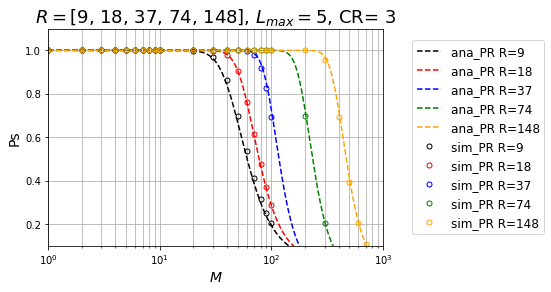

In [173]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

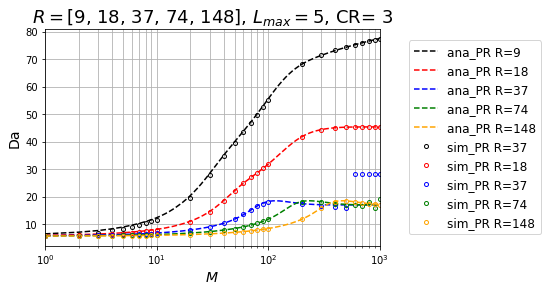

In [174]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.xlim(1, sta_max)
plt.show()

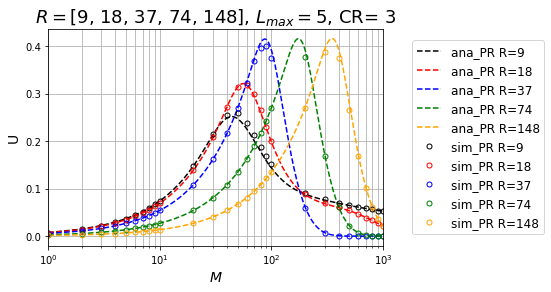

In [177]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.xlim(1, sta_max)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# CR=6

In [165]:
R = [9,18,37,74,148]
Lmax = 5
# sta_max = 200
sta_max = 1000

m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]


for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=6, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U

In [166]:
# Simulation (old -> m=200)
# m_list_simu = [(i+1)*10 for i in range(20)]
m_list_simu = np.concatenate([np.arange(1, 11, 1), np.arange(20, 110, 10), np.arange(200, 1100, 100)])

ps_list_simu_9 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998888888888889, 1.0, 0.9980500000000007, 0.9674333333333305, 0.8616750000000004, 0.6980000000000003, 0.5355833333333335, 0.41287142857142606, 0.31779999999999975, 0.25313333333333354, 0.20378999999999972, 0.061619999999999994, 0.03551000000000008, 0.023847499999999966, 0.017569999999999898, 0.013706666666666707, 0.011397142857142837, 0.00975, 0.008089999999999983, 0.00718599999999996]
da_list_simu_9 = [5.672999999999856, 6.25448249999986, 6.860547999999878, 7.781937749999947, 8.409655199999989, 8.986977499999988, 9.539554714285671, 10.296495000000021, 11.130504791666633, 11.642697900000039, 19.713182344736953, 27.9869665763776, 34.660951749786534, 39.619466032931804, 43.419130238110114, 46.795666356793845, 49.82514690254479, 52.69838976579044, 55.10534126377412, 68.11606833729336, 71.5403931759626, 73.19700521897447, 74.39391830053705, 75.19788484011153, 76.00698932284708, 76.55251409308202, 77.12108218747356, 77.53082220318043]
t_list_simu_9 = [0.06666666666666801, 0.13333333333333602, 0.19999999999999718, 0.26666666666667205, 0.3333333333333318, 0.39999999999999436, 0.46666666666665557, 0.5333333333333441, 0.5999333333333446, 0.6666666666666636, 1.3307333333333278, 1.934866666666661, 2.297800000000008, 2.326666666666674, 2.142333333333334, 1.92673333333333, 1.694933333333331, 1.5187999999999973, 1.3586000000000027, 0.8215999999999992, 0.7102000000000015, 0.6359333333333357, 0.5856666666666681, 0.548266666666668, 0.5318666666666672, 0.5200000000000002, 0.48539999999999933, 0.47906666666666575]
u_list_simu_9 = [0.007407407407407279, 0.014814814814814559, 0.02222222222222215, 0.029629629629629117, 0.0370370370370375, 0.0444444444444443, 0.051851851851851004, 0.059259259259258235, 0.06665925925926061, 0.074074074074075, 0.14785925925926102, 0.21498518518518678, 0.25531111111111204, 0.2585185185185187, 0.23803703703703763, 0.21408148148148168, 0.18832592592592587, 0.16875555555555521, 0.15095555555555557, 0.0912888888888889, 0.07891111111111121, 0.07065925925925932, 0.06507407407407412, 0.06091851851851861, 0.059096296296296286, 0.057777777777777685, 0.05393333333333343, 0.053229629629629675]
power_list_simu_9 = [1.0, 1.157, 1.3173333333333328, 1.5665, 1.741600000000003, 1.8900000000000001, 2.0462857142857205, 2.24775, 2.5271249999999985, 2.6494000000000035, 5.682983625730995, 10.21212436333115, 16.46131395812282, 25.125324721859318, 36.96894031261364, 51.32463095302585, 69.63935485870815, 89.84191646465679, 113.82743704196344, 395.0009179433118, 691.3796267112483, 1037.6095589599945, 1446.547273598621, 1851.1564833205998, 2224.2430710612985, 2621.0436452436447, 3189.8708413645168, 3613.1886252636136]


ps_list_simu_18 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9987000000000001, 0.9784750000000051, 0.9039200000000028, 0.7636666666666663, 0.6153142857142864, 0.47917500000000024, 0.36905555555555464, 0.28930000000000056, 0.06346500000000008, 0.033313333333333334, 0.02183999999999995, 0.015699999999999947, 0.01124666666666667, 0.008065714285714263, 0.005988749999999994, 0.0043533333333333184, 0.0030899999999999582]
da_list_simu_18 = [5.672999999999856, 5.933957999999861, 6.136294999999874, 6.382124999999911, 6.614717999999955, 6.934296999999919, 7.158515571428512, 7.386955125000014, 7.572194333333328, 7.940498100000036, 10.91144820000004, 14.589051492857152, 18.49493024473398, 22.158492755850713, 24.967410428596672, 27.054505908683687, 28.737818348858568, 30.331689520301623, 31.856206477435077, 41.78601492437801, 44.43599382724436, 45.121510033395055, 45.307199897001965, 45.353422404871296, 45.37222124862845, 45.38194936603156, 45.383999999998856, 45.38399999999888]
t_list_simu_18 = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 2.5, 3.745125, 4.892375, 5.6495, 5.7275, 5.384, 4.79175, 4.151875, 3.61625, 1.586625, 1.24925, 1.092, 0.98125, 0.8435, 0.70575, 0.598875, 0.48975, 0.38625]
u_list_simu_18 = [0.0069444444444445785, 0.013888888888889157, 0.02083333333333324, 0.027777777777778314, 0.03472222222222164, 0.04166666666666648, 0.048611111111111965, 0.05555555555555663, 0.0625, 0.06944444444444328, 0.13888888888888656, 0.20806250000000232, 0.2717986111111094, 0.3138611111111112, 0.31819444444444495, 0.29911111111111116, 0.26620833333333344, 0.23065972222222253, 0.20090277777777757, 0.08814583333333326, 0.06940277777777769, 0.06066666666666671, 0.05451388888888902, 0.046861111111111166, 0.039208333333333414, 0.033270833333333354, 0.027208333333333362, 0.02145833333333335]
power_list_simu_18 = [1.0, 1.094, 1.1633333333333338, 1.2625, 1.3423999999999967, 1.4706666666666643, 1.544857142857147, 1.638, 1.708888888888883, 1.8600000000000008, 3.2540000000000058, 5.490994252873561, 8.76430198388619, 13.52527609946168, 20.4831200143775, 29.416898768467654, 41.416904938240755, 57.31543402045146, 76.02015100857768, 383.8323530250971, 740.9179715620963, 1144.5903663003674, 1588.0943126318089, 2289.5958891108926, 3403.921010101019, 4662.932380952378, 6621.043603896099, 9113.010714285716]


ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99995, 0.9996200000000001, 0.9948666666666676, 0.9763999999999977, 0.9181875000000007, 0.8251777777777778, 0.693629999999999, 0.0557149999999999, 0.0041733333333333475, 0.00033500000000000023, 2.0000000000000005e-05, 1.6666666666666669e-06, 0.0, 0.0, 0.0, 0.0]
da_list_simu_37 = [5.672999999999856, 5.772277499999858, 5.930175999999868, 6.009125249999888, 6.095071199999907, 6.245027499999898, 6.398333571428481, 6.465092624999965, 6.569964333333286, 6.652159800000002, 7.80264420000004, 9.003429200000012, 10.303339922368487, 11.840259063724474, 13.558942024196774, 15.132859207472263, 16.58499434183273, 17.525227473101737, 18.039201557655918, 17.38897121229356, 16.78389547383302, 16.19261811023622, 16.073500000000003, 28.365000000000002, 28.365000000000002, 28.365000000000002, 28.365000000000002, 28.365000000000002]
t_list_simu_37 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 7.9996, 9.9962, 11.938400000000023, 13.669600000000056, 14.691000000000011, 14.853199999999996, 13.872600000000004, 2.2286000000000024, 0.2503999999999991, 0.026799999999999942, 0.0019999999999999996, 0.0002, 0.0, 0.0, 0.0, 0.0]
u_list_simu_37 = [0.005405405405405471, 0.010810810810810942, 0.016216216216216387, 0.021621621621621883, 0.02702702702702728, 0.032432432432432774, 0.03783783783783734, 0.043243243243243766, 0.048648648648649366, 0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21620540540540742, 0.2701675675675632, 0.3226594594594587, 0.3694486486486489, 0.3970540540540538, 0.4014378378378373, 0.37493513513513466, 0.060232432432432856, 0.006767567567567603, 0.0007243243243243224, 5.405405405405406e-05, 5.405405405405406e-06, 0.0, 0.0, 0.0, 0.0]
power_list_simu_37 = [1.0, 1.035, 1.0933333333333333, 1.1205, 1.1511999999999976, 1.208666666666667, 1.2628571428571462, 1.2915, 1.3286666666666571, 1.357600000000006, 1.8541999999999992, 2.483133333333335, 3.306818421052635, 4.510076292517002, 6.186028143401924, 8.222501246584896, 11.316046385940155, 15.263468859971187, 21.260423637893545, 444.04353074820915, 3416.9565666666676, 1134.424, 97.616, 13.8, 0.0, 0.0, 0.0, 0.0]


ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999714285714285, 1.0, 0.9998888888888888, 0.9995100000000002, 0.697145, 0.20689666666666684, 0.056367499999999876, 0.015815999999999924, 0.0045183333333333135, 0.0011771428571428575, 0.0003874999999999979, 9.444444444444428e-05, 2.300000000000001e-05]
da_list_simu_74 = [5.672999999999856, 5.760931499999856, 5.7996969999998615, 5.860208999999873, 5.907862199999882, 5.971777999999878, 5.987446285714164, 6.0672734999999225, 6.136925333333246, 6.190944899999954, 6.71002440000002, 7.291506900000003, 7.819521375000055, 8.438474040000001, 9.080771099999996, 9.695435882773097, 10.35726701250005, 11.146453657575758, 11.853493723529265, 18.036633345609967, 17.980987338953856, 17.471302426049863, 17.024656656412755, 16.886947986732487, 16.612215116279003, 18.078791208791134, 15.828370370370372, 19.33977272727273]
t_list_simu_74 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 13.999600000000001, 16.0, 17.998, 19.990199999999998, 27.8858, 12.41379999999999, 4.509400000000004, 1.5815999999999988, 0.5421999999999985, 0.16479999999999995, 0.062000000000000235, 0.016999999999999973, 0.004600000000000002]
u_list_simu_74 = [0.0027027027027027354, 0.005405405405405471, 0.008108108108108194, 0.010810810810810942, 0.01351351351351364, 0.016216216216216387, 0.01891891891891867, 0.021621621621621883, 0.024324324324324683, 0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891837837837858, 0.21621621621621823, 0.2432162162162219, 0.2701378378378335, 0.3768351351351354, 0.16775405405405397, 0.06093783783783786, 0.021372972972973015, 0.007327027027027064, 0.0022270270270270207, 0.0008378378378378331, 0.00022972972972972974, 6.216216216216216e-05]
power_list_simu_74 = [1.0, 1.033, 1.044666666666666, 1.067, 1.0843999999999985, 1.1059999999999994, 1.1120000000000008, 1.14075, 1.1682222222222178, 1.1862000000000037, 1.3840999999999997, 1.6235333333333335, 1.8536000000000021, 2.1648400000000017, 2.5137333333333314, 2.893957983193279, 3.339000000000001, 3.9410292929292967, 4.528508221750426, 20.927975438582294, 100.64471335206116, 413.50810954901004, 1715.5181221448133, 5931.125252380955, 7175.692499999999, 4704.012, 1634.132, 494.261]


ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997200000000003, 0.954873333333343, 0.6943449999999997, 0.3945119999999998, 0.2076150000000003, 0.10767285714285672, 0.057146250000000086, 0.029641111111111226, 0.016071999999999986]
da_list_simu_148 = [5.672999999999856, 5.695691999999856, 5.733511999999859, 5.765186249999863, 5.790998399999869, 5.823334499999871, 5.841569142857015, 5.895665249999896, 5.913156999999894, 5.915237099999904, 6.228103049999988, 6.467219999999987, 6.748317150000013, 7.007403059999997, 7.291601449999991, 7.574832728571431, 7.844269837500042, 8.139494333333337, 8.415668580000004, 11.877261515599743, 15.964431607436875, 18.05264631537547, 18.29423139832767, 18.012917531021596, 17.664179450716308, 17.420979445328612, 17.29902348308819, 17.113146270616355]
t_list_simu_148 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.988799999999976, 57.29239999999996, 55.54759999999999, 39.45120000000001, 24.913799999999974, 15.074200000000001, 9.143399999999993, 5.335400000000002, 3.214400000000004]
u_list_simu_148 = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.2701945945945903, 0.3871108108108117, 0.3753216216216215, 0.2665621621621618, 0.16833648648648636, 0.10185270270270254, 0.06177972972972979, 0.03605000000000001, 0.021718918918918882]
power_list_simu_148 = [1.0, 1.008, 1.0213333333333332, 1.0325, 1.041599999999999, 1.0536666666666663, 1.0594285714285725, 1.0785, 1.0846666666666647, 1.0866000000000013, 1.1985000000000015, 1.2858000000000052, 1.396949999999999, 1.497839999999999, 1.6154666666666677, 1.743657142857143, 1.867125000000002, 2.008111111111108, 2.144439999999997, 4.531751000373957, 9.614908455061046, 21.011865152418988, 46.64351830463393, 99.41857734131602, 203.88437397028454, 398.2951752850154, 794.7440224043854, 1511.0986616894868]

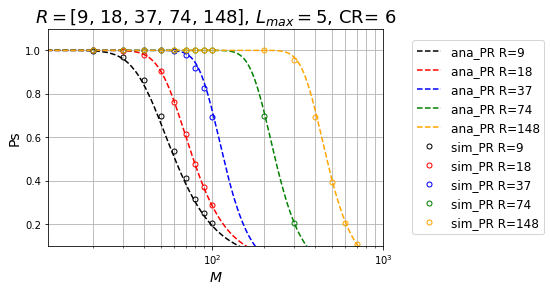

In [178]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([11,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

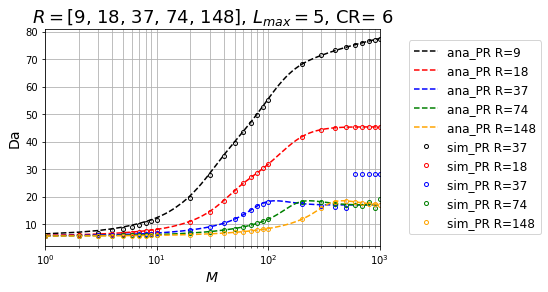

In [180]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.xlim(1,sta_max)

# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

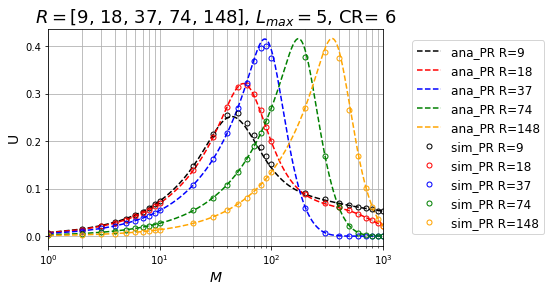

In [181]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.xlim(1,sta_max)

plt.show()